In [3]:
import pandas as pd
import numpy as np

import chess
import chess.svg
import random
import math

import skunk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

# from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [116]:
pd.options.display.max_columns = None # display all col in df
pd.options.display.max_colwidth = None # display all content in a col

# <center>30100 Project 2</center>

<center>Tianze Zhang</center>

## <center>Overview</center>

### Summary

For this project, I am interested in predicting the evaluation and the win chance of chess player from the state of board. Specifically, my dataset consists of a FEN (Forsyth–Edwards Notation) string as the feature (more about FEN string in the data section) and evaluation of the current strength of the board (in centipawns) as the target. I used three models, linear model, polynomial model and a fine-tuned GPT3 model, to attempt this task.

### Intro

Chess AI building and board evaluation has long been a task interested by the machine-learning, and the more general computer science, community. In 1997, the IBM Deep Blue defeated the world champion  Garry Kasparov for the first time, and, since then, human players re no match to the computer chess engines. In the last 20 years, chess engine has grown steadily. Nowadays, publicly available chess engines that can run on home computers can easily defeated the best human player.<br>
<br>
In the past, the primary strategy of building chess AI and evaluation is to first build a static evaluation algorithm of the board (through evaluating pieces on board, their mobility, pawn structure, king safety…); then, the chess engine will search possible future moves in alpha-beta pruned search tree and looking for best moves assuming the opponent play perfectly. Later, popular chess engine also incorporate neural networks to make the search more efficiently.


## <center>Data</center>

link: https://www.kaggle.com/datasets/ronakbadhe/chess-evaluations

### Data Description

My dataset consisted of three files: chessData, random_evals and tactic_evals. The first two files consist of a Fen string represent the board and an evaluation score in centipawns; the last one additionally contains a best move in UCI form. Since I am not interested in the best move, the third file, tactic_evals, is irrelevant to me.

chessData and random_evals includes 12954834 and 1000273 samples, respectively. For this project, I do not plan to use all 13 million training samples. Thus, for simplicity, I only load the random_evals.csv (with about 1 million data) and select my training and testing samples from there.

Below is a sample view of the first five rows of data.

In [143]:
%%time
file_address = "./random_evals.csv"
df = pd.read_csv(file_address)
df.head()

CPU times: user 1.12 s, sys: 220 ms, total: 1.34 s
Wall time: 1.34 s


,FEN,Evaluation
0,rnbqkb1r/pppppppp/B4n2/8/4P3/8/PPPP1PPP/RNBQK1...,-459
1,rnbqkb1r/pppppppp/5n2/1B6/4P3/8/PPPP1PPP/RNBQK...,-125
2,rnbqkbnr/p1pppppp/8/1p6/4P3/8/PPPP1PPP/RNBQKBN...,+198
3,rnbqkb1r/pppppppp/5n2/8/4P3/7N/PPPP1PPP/RNBQKB...,-155
4,rnbqkbnr/ppppp1pp/8/5p2/4P3/8/PPPP1PPP/RNBQKBN...,+209


#### What is a FEN string

FEN (Forsyth-Edwards Notation) string is a unique representation of the current state of the board. It consisted of the following information:
<ul>
  <li>Pieces on board and their position</li>
  <li>Who to move next</li>
  <li>Castling availability</li>
  <li>Possible En Passant Targets</li>
  <li>Castling availability</li>
  <li>Half move clock (turns since last move of pawn or piece capture, the game is darwn if it reaches 50)</li>
  <li>full move clock (turns passed since the game began)</li>
</ul>

For example, the following board represent the initial state of the game

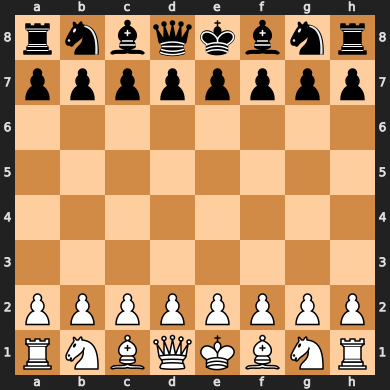

In [118]:
initial_game = chess.Board()
initial_game

Its FEN string is:

In [119]:
initial_game.fen()

'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'

The first part (rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR) are the board fen string. It represents the pieces on each row, separated by “/”. The first row (rnbqkbnr) represent rook, knight, bishop, queen, king, bishop, knight, rook. The second row (pppppppp) means there are 8 pawns. The third row (8) means 8 empty square. The upper-case letter and lower-case letter denoted pieces for white and black respectively. <br>
<br>
The second part (w) means it is white to move next. <br>
<br>
The third part represent castling availability.  KQ means kingside and queenside castling are available for white; kq means kingside and queenside castling are available for black. <br>
<br>
The fourth part (–) means there are no en passant target. <br>
<br>
The last two number are the half move clock and full move clock.

More info here: https://www.chess.com/terms/fen-chess

#### How the evaluation score is computed?

The evaluation of the board is computed by stockfish (version 11), one of the best chess AI today. The reasons I opt for AI evaluated dataset are:
<ol>
  <li>Practically infinite data samples</li>
  <li>Better evaluation than human player, and objective</li>
  <li>Potentially valuable insights from the engine's understanding of the chess</li>
</ol> 

In more details, stockfish evaluate the board in two ways: static evaluation and deep evaluation. The former evaluation is through a static algorithm, considering pre-determined factors, as I mentioned. The deep evaluation is through searching the pruned search tree, and to examine how the current board hold up against the perfect play of the opponent. This is also how stockfish generate the best move (the move that will yield the best evaluation). <br>
<br>
The evaluation I have is computed by stockfish’s deep search with depth of 22, roughly the ability of the best human player in the world.

### Data cleaning and prepocessing 

In [144]:
def dispalyboard(df, indexs):
    boards = []
    labels = []
    for i in indexs:
        board = chess.Board(df.iloc[i][0])
        boards.append(chess.svg.board(board))
        labels.append(f"({str(df.index[i])}) rating: {df.iloc[i][1]}")
    
    row = int(len(labels) / 2)
    svg = skunk.layout_svgs(boards, labels = labels, shape=[row,2], figsize=[10, row * 5])
    plt.close()

    skunk.display(svg)

First, let's display the first six borad and their rating on the dataset. Note that a positive score indicates an advantage for white in centipawns, and a negative score indiciates an advantage for black in centipawns.

In [121]:
dispalyboard(df, list(range(0, 6)))

It seems that all these are actually the begining stage of the game. Scarmble the data and display six more.

In [122]:
df = df.sample(frac=1, random_state = 42).reset_index(drop=True) # shuffle rows
dispalyboard(df, list(range(0, 6)))

In the dataset, sometime the engine will find a checkmate incoming in X turns (checkmate refers a situation king is checked and cannot escape; in other words, it marks the end of the game). It will be denoted as +X if black will be checkmated, -X otherwise.

Let's display six checkmates in the dataset.

In [123]:
# convert target to int, and end checkmated (bool) col
df["Evaluation"] = df["Evaluation"].astype(str)
df['checkmate'] = list(
    map(lambda x: x.startswith('#'), df['Evaluation'])) 

In [124]:
# randomly display 6 checkmated boards 
dispalyboard(df[df['checkmate']], random.sample(range(0, len(df[df['checkmate']])), 6))

Stockfish prune the search tree, and will only consider a portion of moves into the given depth. It means that it will not find all possible checkmates within the given depth, and the checkmates moves it finds may not be the fastest moves (but it will be the most logical moves). However, if stockfish says there will be checkmates, there must be a checkmate within a finite turns.

you can use the following link to find and visualize a future forced checkmate (turn on the local evaluation on top right corner). Below is a board that stockfish find a checkmate at depth 10, you can see the visualization with the below link, where there is a forced checkmate within 8 moves.
https://lichess.org/analysis/fromPosition/8/7p/8/5R2/r3pP2/3pK2P/p1k5/8_b_-_-_0_43

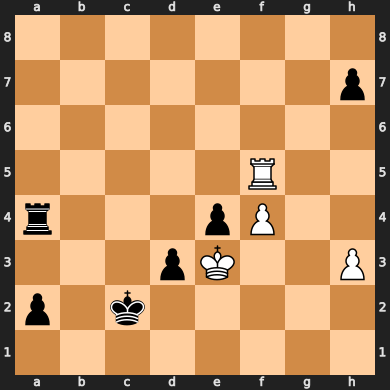

In [125]:
chess.Board('8/7p/8/5R2/r3pP2/3pK2P/p1k5/8 b - - 0 43')

Since whethere there is forced checkmate coming is something can be determined deterministically through a brute-force search; also, the current board strength is irrealvant since the winner is already decided. There is little point to predict checkmates through machine learning, so I drop all rows with a checkmate coming.

In [126]:
# convert stirng to int, and handle error
# this dataset has one error,the evaluation is "+23" instead of '23'
def to_int(s):
    try:
        return int(s)
    except:
        if s[0] == '+':
            return int(s[1:])

In [127]:
# drop checkmates and also convert Evaluation to int
df.drop(df[df['checkmate']].index, inplace=True)
df["Evaluation"] = df["Evaluation"].apply(to_int)
df

,FEN,Evaluation,checkmate
1,5rk1/1pq2pbp/3pbnp1/2n5/2P1p3/2NPP1P1/1B2NPBP/3QK2R w K - 0 16,-100,False
2,r1bqk2r/ppp1ppbp/2np2pn/6N1/2BP2P1/2N1P3/PPP2P1P/R1BQK2R w KQkq - 1 8,40,False
3,r1bqr1k1/pp2n1bp/2pBp1p1/2P2pN1/3P2n1/5N2/PP3PBP/RQ2R1K1 b - - 1 17,-90,False
4,2r5/4R3/p2p4/3p1k2/8/4B3/PP4PP/6K1 b - - 4 29,669,False
5,rnb1kbnr/p1q1pppp/1ppp4/8/2P3P1/4PN1P/PP1P1P2/RNBQKB1R b KQkq - 0 5,35,False
...,...,...,...
1000268,r2q1rk1/pp1nbpp1/2p2n1p/3p4/P2P2bB/3B1N2/1PPN1PPP/R2QR1K1 b - - 0 11,-27,False
1000269,r1b1r2k/1p1n1pp1/p7/1Bppq3/7P/4P3/PPQ1NPP1/R4RK1 b - - 1 18,-578,False
1000270,r1b2rk1/p4p2/2p2Q1B/4P3/B2q4/6KP/P5P1/R6R b - - 9 27,1278,False
1000271,rnbqk1nr/pppp1ppp/8/2b1p3/1P2P3/P4N2/2PP1PPP/RNBQKB1R w KQkq - 1 5,513,False


In [128]:
df.drop(columns = ["checkmate"], inplace = True)

### Data normalization and transformation

First, let's display the description and the distribution of evaluation score in centipawns (target), in log scale.

In [129]:
df["Evaluation"].describe()

count    944009.000000
mean         10.250104
std        1067.625440
min      -15265.000000
25%        -386.000000
50%           5.000000
75%         401.000000
max       14489.000000
Name: Evaluation, dtype: float64

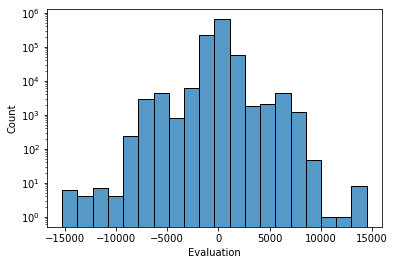

In [130]:
# histogram of evaluation with log scale
g = sns.histplot(df["Evaluation"], bins = 20)
g.set_yscale("log")

From the graph, we can tell that the distribution has extremely long tails to both sides, with over 1 million games near the center and 10 games near the edge. This is expected, since most games should have roughly equal strength for both sides.

Display some extreme cases.

In [131]:
df_extreme = df[abs(df["Evaluation"]) > 1e4]
df_extreme = df_extreme.sort_values("Evaluation")
df_extreme

,FEN,Evaluation
160745,8/8/2q5/5k2/2K5/8/8/8 w - - 8 55,-15265
461203,8/4b3/7p/4K2P/5PP1/1k6/8/1q6 w - - 2 51,-15265
825132,8/4b3/p1Q1P3/1p1K1k2/2pP1P2/2Pq4/P6P/8 w - - 6 41,-15113
709386,8/p6K/1k4PN/8/8/2p5/8/1q6 b - - 1 64,-14869
177718,6k1/5pp1/7p/2q1p3/4P1P1/5K2/8/8 w - - 4 62,-14170
19998,6k1/5pp1/7p/4Kq2/6P1/8/4p3/8 w - - 2 69,-13927
25784,6k1/5p2/5Pp1/p6p/bp6/1q1p2Q1/6PP/4rK2 w - - 0 39,-13564
557234,6k1/5pp1/3q3p/4p3/4P1P1/5K2/8/8 w - - 4 62,-13230
293769,r5k1/2p2ppp/2P2q2/Q3N3/8/8/P4PPP/3b2K1 b - - 1 24,-12783
115366,7r/p4p2/5P1b/2p1k2p/1pP2p2/1P1P1K1P/8/8 b - - 5 35,-12418


and visualize them:

In [132]:
dispalyboard(df_extreme, [0, 1, -1 , -2])

In all of this game, except the game 1459229, one side hold a significant advantage because one of their pawns is about to be promoted. Promotion happens when a pawn from one side move to the last rank (the bottom line of the other side): when this happens, pawn can be replaced by queen, knight, bishop, or rook of the same color. Obviously, pawn will be promoted to queen at most times since it is the strongest. This is one reason why evaluation strongly favor one side.


In fact, checkmate can be forseen in most of these games. For example, stockfish version 14 with deeper depth can foresee a checkmate in game 8487344.
https://lichess.org/analysis/fromPosition/8/5PK1/4q3/6Q1/8/8/8/1k6_b_-_-_12_86

As such, I decide to drop all games with the absolute value of evaluation above 2500 (25 pawns).  This is roughly 3 IQR above or below the Q1 and Q3. The board strength difference above that level may serve little practical usage in real games.

In [133]:
# drop outliers
Q1 = df['Evaluation'].quantile(0.25)
Q3 = df['Evaluation'].quantile(0.75)
IQR = Q3 - Q1

print(Q1, Q3, IQR)

-386.0 401.0 787.0


<AxesSubplot:xlabel='Evaluation', ylabel='Count'>

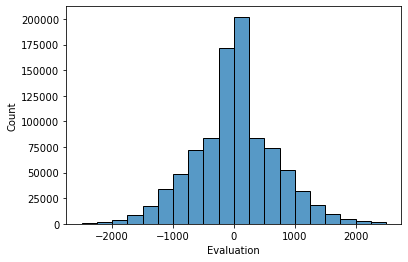

In [134]:
df.drop(df[df['Evaluation'] > 2500].index, inplace=True)
df.drop(df[df['Evaluation'] < -2500].index, inplace=True)

# the scale is linear now
sns.histplot(df["Evaluation"], bins = 20)

I also decided to cut my sample size to 1000000, the maximum amount I will need for my models.

In [135]:
df = df.sample(frac=1, random_state = 42).reset_index(drop=True) # shuffle rows
df = df[:1000000]

Then, I decide to normalize the evaluation score through a sigmoid function, for two reasons:

<ol>
  <li>The absolute pawn advantage has little purpose in real games: for example, the difference between 10 pawns advantage and a 12 pawns advantage is much smaller than a difference between 2 pawns advantage and a 0 pawns advantage. In the case, the winner is mostly decided already. </li>
      <li> There may not be enough data for board with high absolute evaluation score </li>
</ol>

The specfic function I use is $$\Large win\_rate = \frac{1}{1 + 10 ^ \frac{-cp}{400}}$$, where cp is the evalution score in centipawns.

In [136]:
# normalize evaluation through sigmod function

df["win_rate"] = 1 / (1 + 10 ** (-df["Evaluation"] / 400))
df["win_rate"].describe()

count    9.241420e+05
mean     5.073424e-01
std      3.698660e-01
min      5.623410e-07
25%      1.056800e-01
50%      5.071951e-01
75%      9.022073e-01
max      9.999994e-01
Name: win_rate, dtype: float64

<AxesSubplot:xlabel='win_rate', ylabel='Count'>

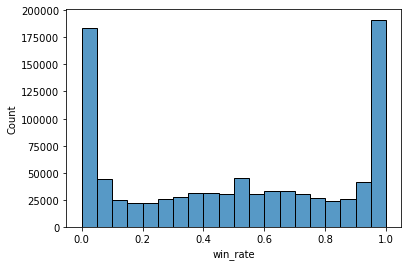

In [137]:
g = sns.histplot(df["win_rate"], bins = 20)
g

### Exploratory Data Analysis

In [138]:
def generate_board_info(fen):
    board, w_move_next, castling, en_passant, h_move, f_move  = fen.split(" ")
    
    bp = board.count('p')
    wp = board.count('P')
    br = board.count('r')
    wr = board.count('R')
    bk = board.count('n')
    wk = board.count('N')
    bb = board.count('b')
    wb = board.count('B')
    bq = board.count('q')
    wq = board.count('Q')
    w_move_next = int(w_move_next == 'w')
    
    castlings = [0, 0, 0, 0]
    if "K" in castling:
        castlings[0] = 1
    if "Q" in castling:
        castlings[1] = 1
    if "k" in castling:
        castlings[2] = 1
    if "q" in castling:
        castlings[3] = 1
    
    if en_passant == "-":
        en_passant = 0
    else:
        en_passant = 1
        
    return [bp, wp, br, wr, bk, wk, bb, wb, bq, wq, w_move_next, *castlings, en_passant, int(h_move), int(f_move)]

fen = "8/5k2/3p4/1p1Pp2p/pP2Pp1P/P4P1K/8/8 b - - 99 50"
generate_board_info(fen)

[6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 99, 50]

In [139]:
%%time
df_board = df.apply(lambda x : generate_board_info(x[0]), axis='columns', result_type='expand')

CPU times: user 19.6 s, sys: 188 ms, total: 19.8 s
Wall time: 19.8 s


In [140]:
df_board = pd.concat([df_board, df["win_rate"]], axis=1)
df_board.columns = ["b_pawn", "w_pawn", "b_rook", "w_rook", "b_knight", "w_knight", "b_bishop", "w_bishop", "b_queen", \
                     "w_queen", "white_move", "w_king_castling", "w_queen_castling", "b_king_castling", "b_queen_castling", \
                   "en_passant", "half_move", "full_move", "win_rate"]
df_board

,b_pawn,w_pawn,b_rook,w_rook,b_knight,w_knight,b_bishop,w_bishop,b_queen,w_queen,white_move,w_king_castling,w_queen_castling,b_king_castling,b_queen_castling,en_passant,half_move,full_move,win_rate
0,8,8,2,2,1,2,2,2,1,1,1,1,1,0,1,0,1,8,0.999798
1,5,6,1,1,1,0,0,1,0,0,0,0,0,0,0,0,2,29,0.293025
2,5,6,2,2,1,0,0,1,0,0,0,0,0,0,0,0,1,27,0.993621
3,6,6,2,2,0,1,0,1,1,1,1,0,0,0,0,0,1,33,0.999945
4,7,5,2,1,1,2,1,1,1,1,0,0,0,0,0,0,2,21,0.000193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924137,8,8,2,2,2,2,2,2,1,1,0,1,1,1,0,0,0,10,0.524445
924138,6,4,1,1,0,0,1,1,1,1,0,0,0,0,0,0,8,29,0.003898
924139,7,8,2,2,2,2,2,2,1,1,1,0,0,1,1,0,3,11,0.999513
924140,8,8,2,2,2,2,2,2,1,1,1,1,1,1,1,0,0,4,0.624002


Below are histograms of the distribution of number of pawn for both sides:

<AxesSubplot:xlabel='w_pawn', ylabel='Count'>

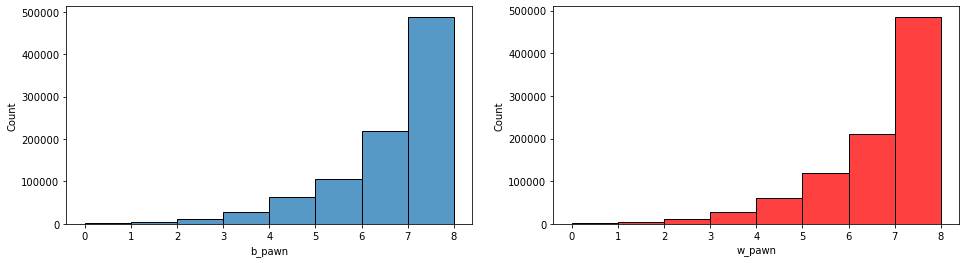

In [141]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

sns.histplot(df_board["b_pawn"], bins = 8, ax = axes[0])    
sns.histplot(df_board["w_pawn"], bins = 8, color = 'r', ax = axes[1])

Below are histograms of the distribution of number of rooks, knights and bishops for both sides:

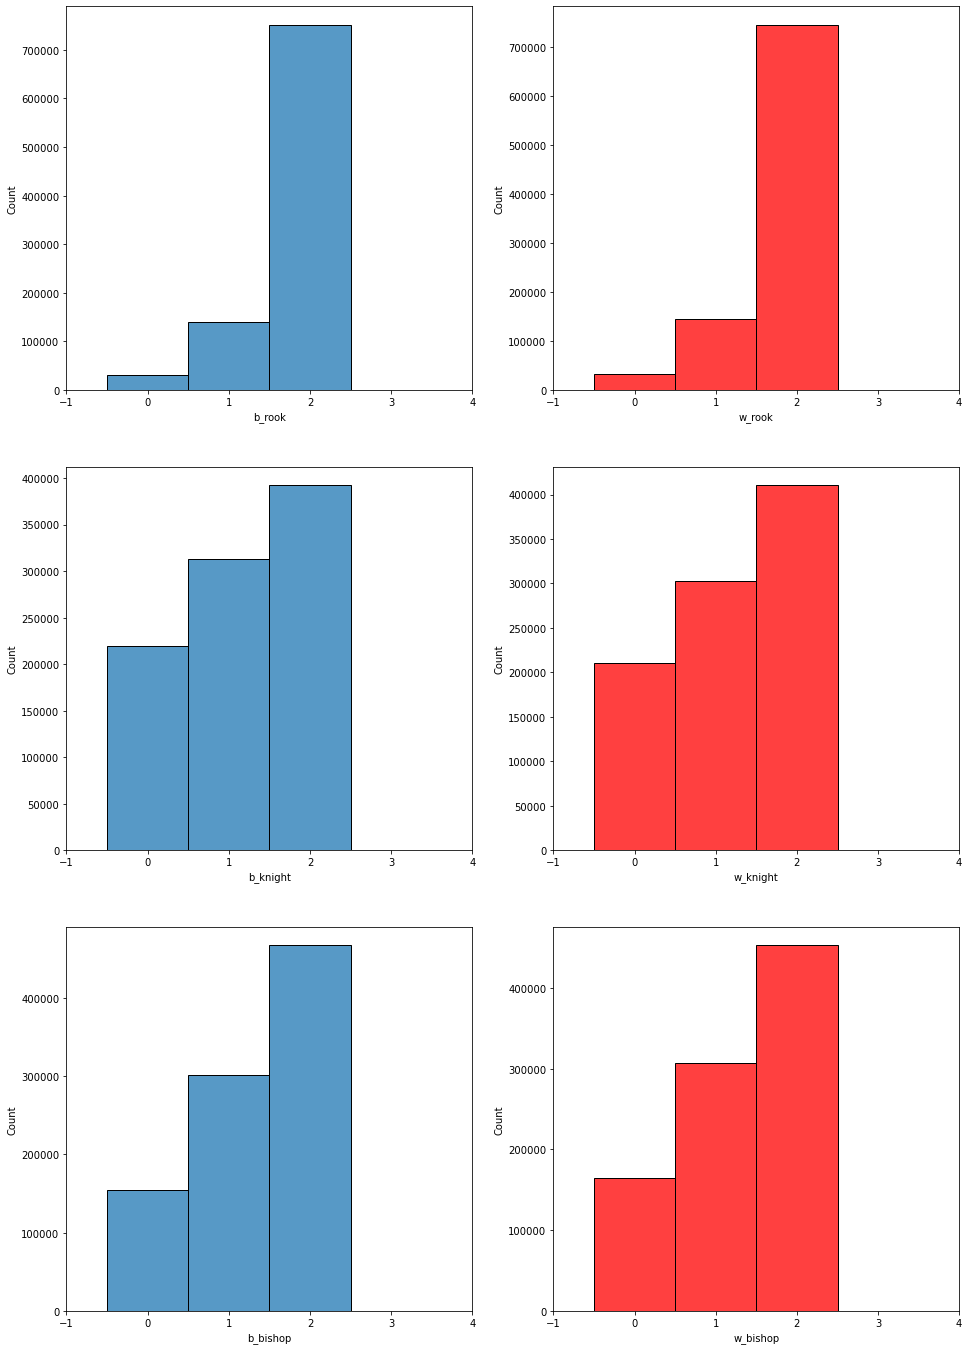

In [142]:
_, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,24))

r1 = ["b_rook", "b_knight", "b_bishop"]
r2 = ["w_rook", "w_knight", "w_bishop"]

for i in range(3):
    ax = axes[i, 0]
    b = sns.histplot(df_board[r1[i]], bins = 4, ax = ax, discrete = True)
    ax.set_xticks(ax.get_xticks()[::2])

for i in range(3):
    ax = axes[i, 1]
    sns.histplot(df_board[r2[i]], bins = 4, color = 'r', ax = ax, discrete = True)
    ax.set_xticks(ax.get_xticks()[::2])

Below are histograms of the distribution of number of queen on both sides:

Text(0.5, 0, 'black queen')

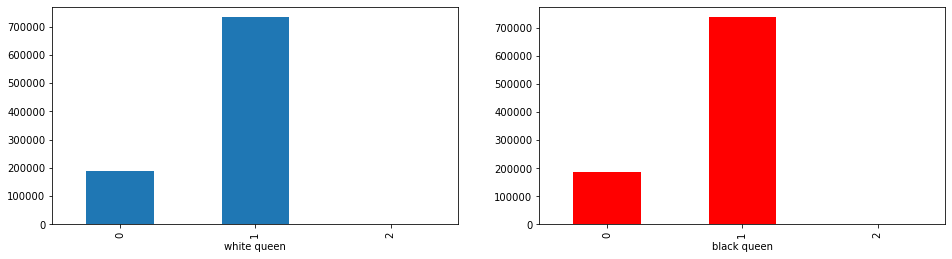

In [143]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

df_board['w_queen'].value_counts().sort_index(ascending=True).plot(kind='bar', ax = axes[0])
df_board['b_queen'].value_counts().sort_index(ascending=True).plot(kind='bar', ax = axes[1], color = 'r')

axes[0].set_xlabel("white queen")
axes[1].set_xlabel("black queen")

For white, there are 169 boards with 2 queens; for black, there are 90. It is a result of promotion of pawns.

As you can see, the distributions of pieces count are roughly symmetrical, which is expected. Now, we graph other variables.

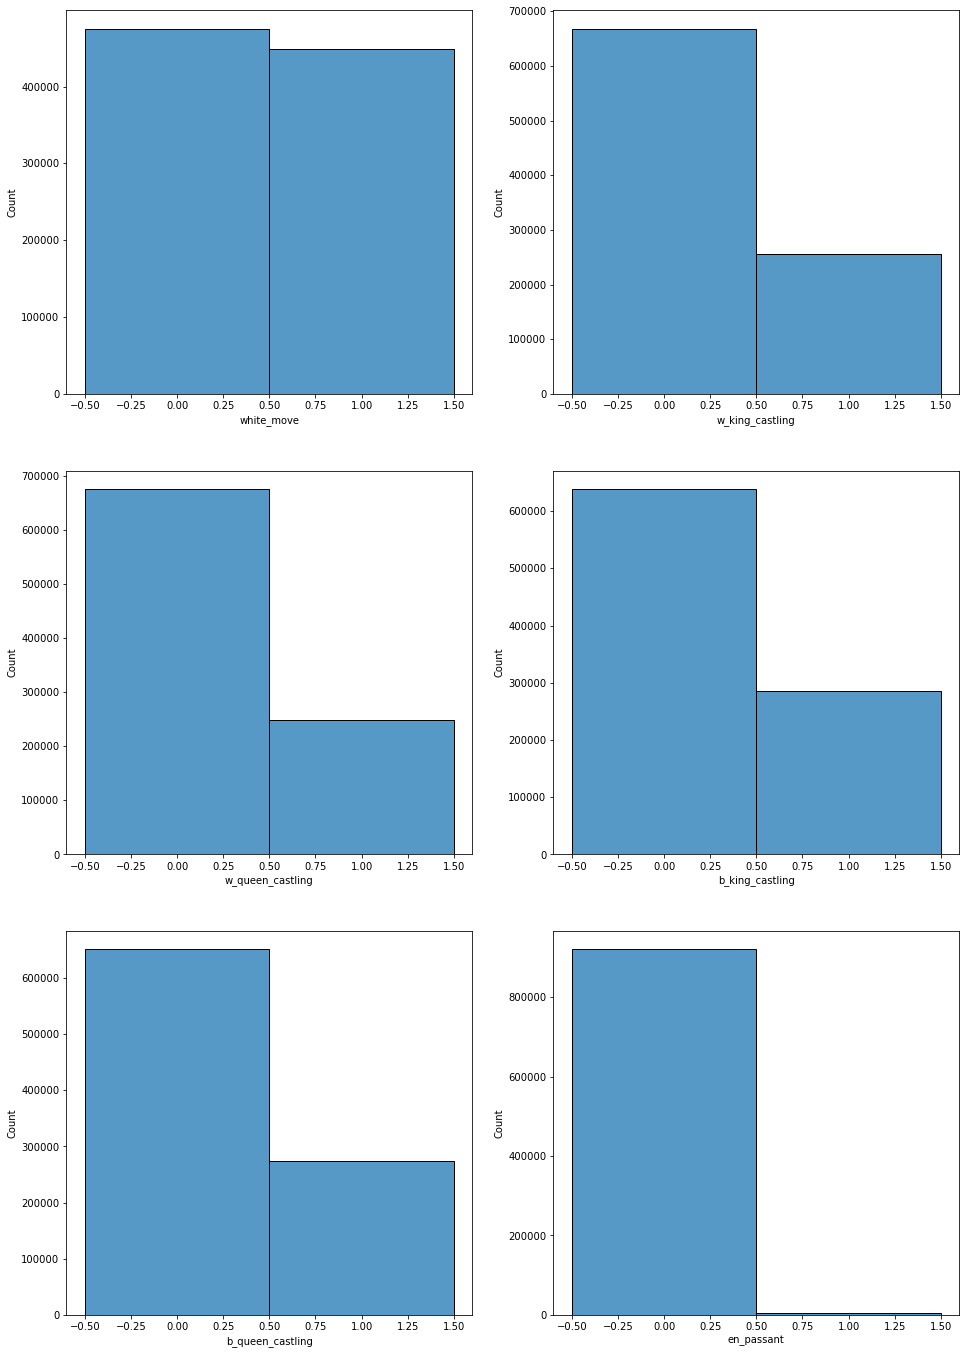

In [144]:
f = ["white_move", "w_king_castling", "w_queen_castling", "b_king_castling", "b_queen_castling", "en_passant"]
_, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,24))

for i in range(6):
    b = sns.histplot(df_board[f[i]], bins = 2, ax = axes[int(i / 2), i % 2], discrete = True)

and box plots for full move and half move:

Text(0.5, 1.0, 'full_move')

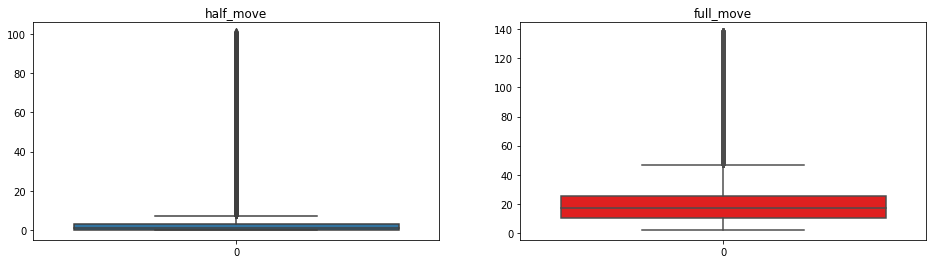

In [145]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

sns.boxplot(df_board["half_move"], ax = axes[0])    
sns.boxplot(df_board["full_move"], color = 'r', ax = axes[1])

axes[0].set_title("half_move")
axes[1].set_title("full_move")

In real life, when the half move clock reaches 50, the game is considered as a drawn, or at least either side can request a drawn (depends on the specific rules of platforms or the tournament). It is not very common. Thus, I drop all rows with half_move > 50.

In [146]:
df_board.drop(df[df_board["half_move"] > 50].index, inplace=True)
df_board

,b_pawn,w_pawn,b_rook,w_rook,b_knight,w_knight,b_bishop,w_bishop,b_queen,w_queen,white_move,w_king_castling,w_queen_castling,b_king_castling,b_queen_castling,en_passant,half_move,full_move,win_rate
0,8,8,2,2,1,2,2,2,1,1,1,1,1,0,1,0,1,8,0.999798
1,5,6,1,1,1,0,0,1,0,0,0,0,0,0,0,0,2,29,0.293025
2,5,6,2,2,1,0,0,1,0,0,0,0,0,0,0,0,1,27,0.993621
3,6,6,2,2,0,1,0,1,1,1,1,0,0,0,0,0,1,33,0.999945
4,7,5,2,1,1,2,1,1,1,1,0,0,0,0,0,0,2,21,0.000193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924137,8,8,2,2,2,2,2,2,1,1,0,1,1,1,0,0,0,10,0.524445
924138,6,4,1,1,0,0,1,1,1,1,0,0,0,0,0,0,8,29,0.003898
924139,7,8,2,2,2,2,2,2,1,1,1,0,0,1,1,0,3,11,0.999513
924140,8,8,2,2,2,2,2,2,1,1,1,1,1,1,1,0,0,4,0.624002


Below is a corrlation heat map

CPU times: user 989 ms, sys: 88.1 ms, total: 1.08 s
Wall time: 925 ms


<AxesSubplot:>

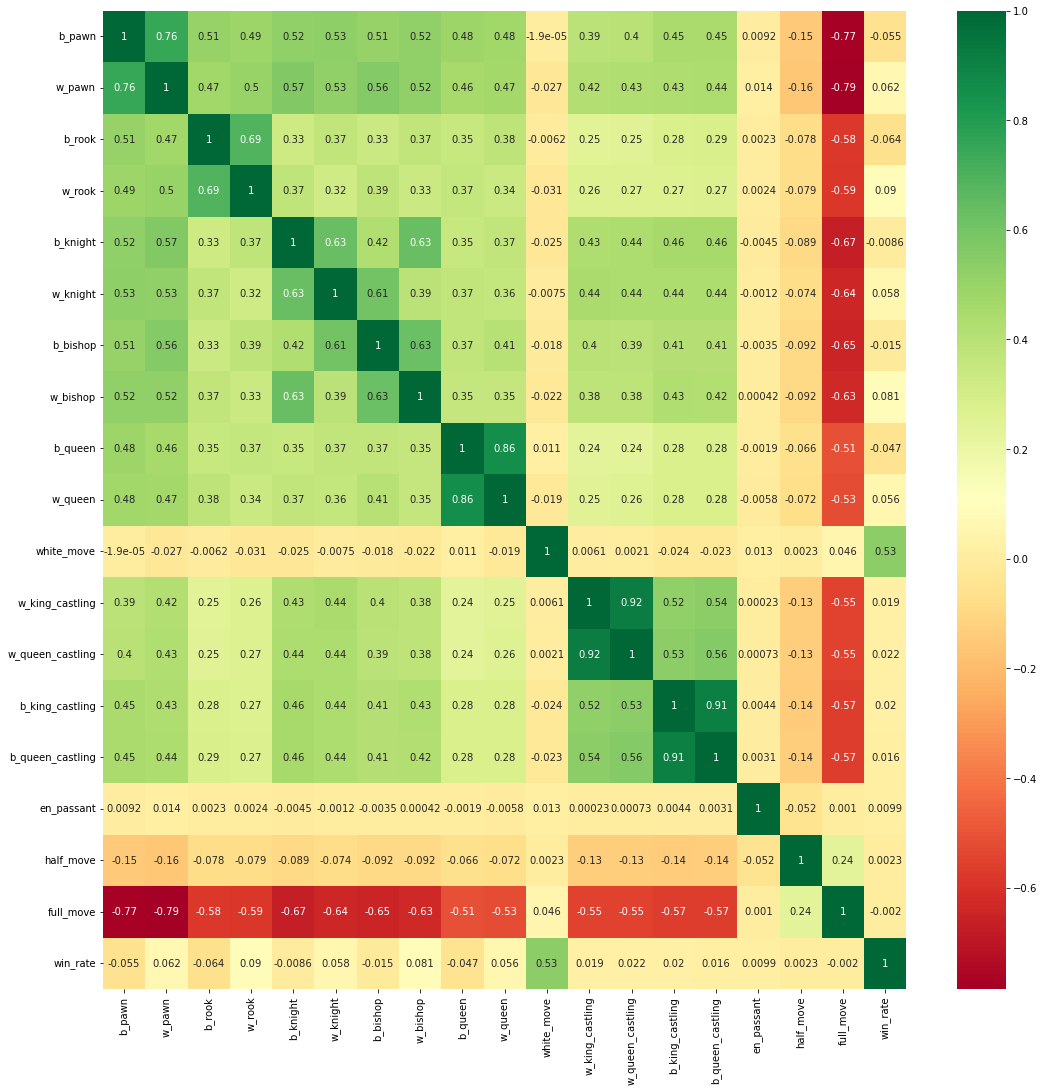

In [147]:
%%time
_, ax = plt.subplots(figsize=(18,18))
columns = df_board.columns
sns.heatmap(df_board[columns].corr(),annot=True,cmap='RdYlGn', ax=ax)

Obviously, the correlation between number of pieces of both sides are high, as they are all connected to a third variable, the state of the game (early game, mid game, or end game). I decide to not drop any of these variables: one goal of the project is to build an explainable model, and it does not make much sense to simply a piece on board. 


We can also observe that the kingside castling and queenside castling are highly correlated: one requirement of castling is that neither the king nor the rook has previously moved, so a move of king will invalid both castling. As such, I drop both w_queen_castling and b_queen_castling.


I also drop the full move clock. Theoretically speaking, how many turns passed should have very minimal effect on the board, given all other states of the board stay the same, possibly besides offset the initial advantage of the white. Furhter, I dropped en_passant, because it shoulld have minimal effect to the state of game, and would require compelx processing to code its effect as a feature.


Finally, there is little correlation between the win rate with any other feature. This is not a surprise, since the win rate is a result of complex interaction between our features.


In [148]:
df_board.drop(columns = ["w_queen_castling", "b_queen_castling", "full_move", "en_passant"], inplace = True)
df_board

,b_pawn,w_pawn,b_rook,w_rook,b_knight,w_knight,b_bishop,w_bishop,b_queen,w_queen,white_move,w_king_castling,b_king_castling,half_move,win_rate
0,8,8,2,2,1,2,2,2,1,1,1,1,0,1,0.999798
1,5,6,1,1,1,0,0,1,0,0,0,0,0,2,0.293025
2,5,6,2,2,1,0,0,1,0,0,0,0,0,1,0.993621
3,6,6,2,2,0,1,0,1,1,1,1,0,0,1,0.999945
4,7,5,2,1,1,2,1,1,1,1,0,0,0,2,0.000193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924137,8,8,2,2,2,2,2,2,1,1,0,1,1,0,0.524445
924138,6,4,1,1,0,0,1,1,1,1,0,0,0,8,0.003898
924139,7,8,2,2,2,2,2,2,1,1,1,0,1,3,0.999513
924140,8,8,2,2,2,2,2,2,1,1,1,1,1,0,0.624002


Then, I convert half_move as counter of how many turns until the 50 turns (50 - half move)

In [149]:
df_board["half_move"] = df_board["half_move"].apply(lambda x : 50 - x)
df_board

,b_pawn,w_pawn,b_rook,w_rook,b_knight,w_knight,b_bishop,w_bishop,b_queen,w_queen,white_move,w_king_castling,b_king_castling,half_move,win_rate
0,8,8,2,2,1,2,2,2,1,1,1,1,0,49,0.999798
1,5,6,1,1,1,0,0,1,0,0,0,0,0,48,0.293025
2,5,6,2,2,1,0,0,1,0,0,0,0,0,49,0.993621
3,6,6,2,2,0,1,0,1,1,1,1,0,0,49,0.999945
4,7,5,2,1,1,2,1,1,1,1,0,0,0,48,0.000193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924137,8,8,2,2,2,2,2,2,1,1,0,1,1,50,0.524445
924138,6,4,1,1,0,0,1,1,1,1,0,0,0,42,0.003898
924139,7,8,2,2,2,2,2,2,1,1,1,0,1,47,0.999513
924140,8,8,2,2,2,2,2,2,1,1,1,1,1,50,0.624002


Below is an overview of features:

<table>
<tr>
    <th>Features</th>
    <th>description</th>
</tr>

<tr>
    <td>b_pawn</td> 
    <td>number of black pawn</td> 
</tr>

<tr>
    <td>w_pawn </td> 
    <td> number of white pawn </td> 
</tr>

<tr>
    <td> 	b_rook	</td> 
    <td> number of black rook </td> 
</tr>
    
<tr>
    <td> w_rook </td> 
    <td> number of white rook </td> 
</tr>

<tr>
    <td> 	b_knight </td> 
    <td> number of black knight </td> 
</tr>

<tr>
    <td> 	w_knight </td> 
    <td> number of white knight </td> 
</tr>

<tr>
    <td> 	b_bishop </td> 
    <td> number of black bishop </td> 
</tr>
    
<tr>
    <td> 	w_bishop </td> 
    <td> number of white bishop </td> 
</tr>

<tr>
    <td> 	b_queen </td> 
    <td> number of black queen </td> 
</tr>

<tr>
    <td> 	w_queen </td> 
    <td> number of white queen </td> 
</tr>

<tr>
    <td> 	white_move </td> 
    <td>dummy variable represents if white is to move next</td> 
</tr>
    
<tr>
    <td> 	w_king_castling </td> 
    <td> dummy variable represents whether white kingside castling is available </td> 
</tr>
<tr>
    <td> 	b_king_castling </td> 
    <td> dummy variable represents whether black kingside castling is available </td> 
</tr>

<tr>
    <td>	half_move </td> 
    <td>half move clock</td> 
</tr>

</table>

## Model 1: linear regression

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

First, we begin considering what chess pieces have left on the board, and who to move next in our linear regression model. Intuitively speaking, waht left on the board and who to move next has cruical effect on evaluation of board strengths.

This is what is called chess material points in chess evaluation. Here, we want to build a model to objectively examine it. For this task, we only use 200000 samples: due to the simplicity of the model, it is unnecessary to use all data.

In [150]:
df_linear = df_board[["b_pawn", "w_pawn", "b_rook", "w_rook", "b_knight", "w_knight", "b_bishop", "w_bishop", "b_queen", \
                     "w_queen", "white_move", "win_rate"]]
df_linear = df_linear[:200000]

In [151]:
df_linear

,b_pawn,w_pawn,b_rook,w_rook,b_knight,w_knight,b_bishop,w_bishop,b_queen,w_queen,white_move,win_rate
0,8,8,2,2,1,2,2,2,1,1,1,0.999798
1,5,6,1,1,1,0,0,1,0,0,0,0.293025
2,5,6,2,2,1,0,0,1,0,0,0,0.993621
3,6,6,2,2,0,1,0,1,1,1,1,0.999945
4,7,5,2,1,1,2,1,1,1,1,0,0.000193
...,...,...,...,...,...,...,...,...,...,...,...,...
200105,8,8,2,2,2,2,2,2,1,1,0,0.448376
200106,3,3,1,1,1,0,0,0,0,0,0,0.022522
200107,5,5,2,2,1,0,1,2,1,1,1,0.501439
200108,5,4,1,1,0,1,0,0,0,0,1,0.950136


In [152]:
X = df_linear.loc[:, df_linear.columns != 'win_rate']
y = df_linear["win_rate"]

# large train_size due to large data size
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 
X_train

,b_pawn,w_pawn,b_rook,w_rook,b_knight,w_knight,b_bishop,w_bishop,b_queen,w_queen,white_move
21753,6,6,1,1,1,1,1,0,1,1,1
124627,5,4,2,1,0,1,0,1,0,0,1
10357,6,4,1,1,0,0,1,1,1,1,0
135241,8,8,2,2,2,2,2,2,1,1,0
49996,3,4,1,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
119949,5,7,0,0,1,1,0,0,1,1,0
103755,8,8,2,2,2,2,2,2,1,1,0
132009,7,7,2,2,2,2,1,1,1,1,1
146948,7,7,2,2,2,1,1,2,1,1,0


In [153]:
y_train

21753     0.050688
124627    0.996545
10357     0.002196
135241    0.619941
49996     0.027875
            ...   
119949    0.869850
103755    0.267493
132009    0.578497
146948    0.487051
122028    0.988321
Name: win_rate, Length: 150000, dtype: float64

In [154]:
train_model = LinearRegression().fit(X_train, y_train)

# get the coefficient of determinant and MSE of the model (train)
cod_train = train_model.score(X_train,y_train)
pred_train = train_model.predict(X_train)
mae_score_train = mean_absolute_error(y_train.to_numpy(), pred_train)

# get the coefficient of determinant and MSE of the model (test)
cod_test = train_model.score(X_test,y_test)
pred_test = train_model.predict(X_test)
mae_score_test = mean_absolute_error(y_test.to_numpy(), pred_test)


print("train:")
print("coefficient of determinant: " + str(cod_train))
print("MAE: " + str(mae_score_train))
print("")

print("test:")
print("coefficient of determinant: " + str(cod_test))
print("MAE: " + str(mae_score_test))

train:
coefficient of determinant: 0.551985550133621
MAE: 0.20128154894443995

test:
coefficient of determinant: 0.5476550563964491
MAE: 0.20249204490841485


In [155]:
coef = [x for x in train_model.coef_]
coef_df = pd.DataFrame(coef, X_train.columns, columns=['Coefficients'])
print(coef_df)

            Coefficients
b_pawn         -0.075620
w_pawn          0.068262
b_rook         -0.332097
w_rook          0.348778
b_knight       -0.218651
w_knight        0.221061
b_bishop       -0.241013
w_bishop        0.259297
b_queen        -0.554307
w_queen         0.570237
white_move      0.419847


### Cross validation

I further cross validation the model.

In [156]:
cross_val_score(train_model, X, y, cv = 5)

array([0.5469888 , 0.55042576, 0.54992714, 0.55596167, 0.55101141])

As you can see, the score does not differ much in cross validation, suggesting the model is stable.

### Error Analysis

In [158]:
# print top five rows witb biggest error
X_test["result"] = y_test
X_test["pred"] = pred_test
X_test["error"] = y_test - pred_test
X_test["error"] = X_test["error"].apply(lambda x : abs(x))
X_test.sort_values(by = ["error"], ascending = False).head()

,b_pawn,w_pawn,b_rook,w_rook,b_knight,w_knight,b_bishop,w_bishop,b_queen,w_queen,white_move,result,pred,error
101275,4,7,2,1,2,0,1,1,1,0,1,0.860451,-0.406336,1.266787
14847,5,5,2,0,1,1,0,1,1,1,0,0.998163,-0.136144,1.134307
103456,0,4,0,0,0,1,0,1,0,1,0,0.500000,1.610844,1.110844
134246,2,0,1,0,0,0,1,0,1,0,1,0.500000,-0.571607,1.071607
54752,0,5,0,0,0,0,0,1,0,1,0,0.500000,1.458046,0.958046


As you can see, the top five rows with biggest error all have predicted value above 1 or below 0. However, as our target is normalized, it is always between 0 and 1 (win rate). Further, let’s print two board (one overpredicted, one underpredicted) to examine the error further.

In [159]:
dispalyboard(df, [103456, 101275])

In [157]:
print(df.iloc[103456])
print("----------------------------")
print(df.iloc[101275])

FEN           7N/3PP1P1/2Q5/1B6/P2k1K2/8/8/8 b - - 0 61
Evaluation                                            0
win_rate                                            0.5
Name: 103456, dtype: object
----------------------------
FEN           Rr2k1nr/1P1b4/3p3p/2pP1p1P/3nP3/2K1B3/1PP2P2/2q5 w k - 1 28
Evaluation                                                            316
win_rate                                                         0.860451
Name: 101275, dtype: object


On the left side, it is a very interesting case. The game there is already over as a draw due to being a stalemate. Stalemate refers to a situation that one side, when it is its turn to move, has no legal move. If that happens, the game will end immediately as a draw, no matter the advantages one side have. Here, it is black’s turn to move, but all square around its king (the only piece) are checked. According to the game rules, king cannot be moved into checked squares. Thus, it is a stalemate.

On the right side, black has the material advantage now. However, it is the white's turn to move, so the rook at b8 will be captured immediately. Then, the black king is in check, so black have to move the king, and its queen is free for white’s bishop to capture. At this moment, white has the advantage, and its pawn at b7 is about to be promoted.

See this link for a board analysis: https://lichess.org/analysis/fromPosition/Rr2k1nr/1P1b4/3p3p/2pP1p1P/3nP3/2K1B3/1PP2P2/2q5_w_k_-_1_28#54

Both cases are edge cases that board's strength cannot be predicted by pieces info alone. It would have incorporated some understanding of game rules, which is beyond linear model’s capability.

### Improve the model

Based on the insights above, I further improve the model by changing all prediction higher than 1 to 1, and lower than 0 to 0.

In [160]:
def round_within_one(x):
    if x > 1:
        return 1
    if x < 0:
        return 0
    return x

In [161]:
X_test.drop(columns=["error", "pred", "result"], inplace = True)
pred_test = X_test
pred_test["predicted"] = train_model.predict(X_test)
pred_test["truth"] = y_test
pred_test["predicted"] = pred_test["predicted"].apply(round_within_one)

In [162]:
print("coefficient of determinant: " + str(r2_score(pred_test["truth"], pred_test["predicted"])))
print("MAE: " + str(mean_absolute_error(y_test.to_numpy(), pred_test["predicted"])))

coefficient of determinant: 0.5636203331016267
MAE: 0.19480592588619403


A slight improvement from above

## Model 2: polynomial regression

In [48]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In this part, I use polynomial model with interaction terms only. The reason for this is because it is a well-known fact that sometimes piece on board can perform "combo attack", which increase the strength of the board beyond simple summation of power of inidiviudal pieces. This is especially the case in end games: what pieces combo can checkmate the opponent is well-studied (refers to https://en.wikipedia.org/wiki/Chess_endgame#Common_types_of_endgames, for more information). 

In [49]:
df_poly = df_board[:500000]

In [166]:
X = df_poly.loc[:, df_board.columns != 'win_rate']
y = df_poly["win_rate"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train

,b_pawn,w_pawn,b_rook,w_rook,b_knight,w_knight,b_bishop,w_bishop,b_queen,w_queen,white_move,w_king_castling,b_king_castling,half_move
359552,8,7,2,2,1,0,2,2,0,0,1,1,0,50
236175,8,8,2,2,2,2,2,2,1,1,1,1,1,49
452884,2,1,1,1,0,0,0,0,0,0,1,0,0,48
34264,8,8,2,2,2,2,1,1,1,1,1,0,0,50
374150,5,4,1,2,0,0,1,0,1,1,0,0,0,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259321,7,7,2,2,1,1,2,2,1,1,1,0,0,41
366051,8,8,2,2,2,2,2,2,1,1,1,1,0,46
131992,8,8,2,2,2,2,2,2,1,1,0,1,1,50
146935,7,7,2,2,2,2,2,2,1,1,0,1,1,50


 First, test parameter interaction_only = [True, False], and degree up 3.

In [51]:
parameters = {'polynomialfeatures__interaction_only':[True, False], 'polynomialfeatures__degree':[1, 2, 3]}

def PolynomialRegression(**kwargs):
    return make_pipeline(PolynomialFeatures(**kwargs), LinearRegression())

clf = GridSearchCV(PolynomialRegression(), parameters, cv = 3, verbose = 2) # 3-fold evaluation to increase speed

In [52]:
clf.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END polynomialfeatures__degree=1, polynomialfeatures__interaction_only=True; total time=   0.2s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__interaction_only=True; total time=   0.2s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__interaction_only=True; total time=   0.2s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__interaction_only=False; total time=   0.2s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__interaction_only=False; total time=   0.2s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__interaction_only=False; total time=   0.2s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__interaction_only=True; total time=   3.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__interaction_only=True; total time=   3.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__interaction_only=True; total time=   3.0s
[CV] END polynomialfeatures_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'polynomialfeatures__interaction_only': [True, False]},
             verbose=2)

In [53]:
df_poly_eval = pd.DataFrame(clf.cv_results_) # interaction = false overfitting at degree = 4
df_poly_eval

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomialfeatures__degree,param_polynomialfeatures__interaction_only,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.165665,0.002967,0.017851,0.003836,1,True,"{'polynomialfeatures__degree': 1, 'polynomialfeatures__interaction_only': True}",0.554646,0.554543,0.551635,0.553608,0.001396,5
1,0.164465,0.001211,0.019917,0.000270,1,False,"{'polynomialfeatures__degree': 1, 'polynomialfeatures__interaction_only': False}",0.554646,0.554543,0.551635,0.553608,0.001396,5
2,2.848619,0.005446,0.131963,0.000244,2,True,"{'polynomialfeatures__degree': 2, 'polynomialfeatures__interaction_only': True}",0.572098,0.571510,0.569325,0.570978,0.001193,4
3,3.489897,0.004248,0.146637,0.001220,2,False,"{'polynomialfeatures__degree': 2, 'polynomialfeatures__interaction_only': False}",0.573248,0.572375,0.570441,0.572021,0.001173,3
4,11.314789,0.030490,0.370210,0.000029,3,True,"{'polynomialfeatures__degree': 3, 'polynomialfeatures__interaction_only': True}",0.596066,0.594615,0.594388,0.595023,0.000743,2
5,16.498736,0.050986,0.498324,0.001780,3,False,"{'polynomialfeatures__degree': 3, 'polynomialfeatures__interaction_only': False}",0.607065,0.605802,0.605702,0.606190,0.000620,1


Note that in the first three degrees, interaction_only = True peforms similarly as interaction_only = False. we further test it to degree 4 (degree higher than 4 will kill the kernel, likly due to memory issue).

In [54]:
parameters = {'polynomialfeatures__interaction_only':[True, False], 'polynomialfeatures__degree':[4]}
clf_interaction = GridSearchCV(PolynomialRegression(), parameters, cv = 2, verbose = 2) # decrease to 2 fold to increase speed
clf_interaction.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END polynomialfeatures__degree=4, polynomialfeatures__interaction_only=True; total time=  35.5s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__interaction_only=True; total time=  35.4s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__interaction_only=False; total time= 1.9min
[CV] END polynomialfeatures__degree=4, polynomialfeatures__interaction_only=False; total time= 1.9min


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'polynomialfeatures__degree': [4],
                         'polynomialfeatures__interaction_only': [True, False]},
             verbose=2)

In [61]:
df_poly_eval_2 = pd.concat([df_poly_eval, pd.DataFrame(clf_interaction.cv_results_)])
df_poly_eval_2.drop(columns = ["rank_test_score"], inplace = True)
df_poly_eval_2.sort_values("mean_test_score", ascending = False, inplace = True)
df_poly_eval_2.reset_index(inplace = True)
df_poly_eval_2

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomialfeatures__degree,param_polynomialfeatures__interaction_only,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score
0,5,16.498736,0.050986,0.498324,0.001780,3,False,"{'polynomialfeatures__degree': 3, 'polynomialfeatures__interaction_only': False}",0.607065,0.605802,0.605702,0.606190,0.000620
1,0,34.054677,0.053209,1.409384,0.000513,4,True,"{'polynomialfeatures__degree': 4, 'polynomialfeatures__interaction_only': True}",0.605934,0.604117,NaN,0.605025,0.000909
2,4,11.314789,0.030490,0.370210,0.000029,3,True,"{'polynomialfeatures__degree': 3, 'polynomialfeatures__interaction_only': True}",0.596066,0.594615,0.594388,0.595023,0.000743
3,1,112.833613,1.006474,2.685859,0.000313,4,False,"{'polynomialfeatures__degree': 4, 'polynomialfeatures__interaction_only': False}",0.585622,0.574875,NaN,0.580248,0.005373
4,3,3.489897,0.004248,0.146637,0.001220,2,False,"{'polynomialfeatures__degree': 2, 'polynomialfeatures__interaction_only': False}",0.573248,0.572375,0.570441,0.572021,0.001173
5,2,2.848619,0.005446,0.131963,0.000244,2,True,"{'polynomialfeatures__degree': 2, 'polynomialfeatures__interaction_only': True}",0.572098,0.571510,0.569325,0.570978,0.001193
6,0,0.165665,0.002967,0.017851,0.003836,1,True,"{'polynomialfeatures__degree': 1, 'polynomialfeatures__interaction_only': True}",0.554646,0.554543,0.551635,0.553608,0.001396
7,1,0.164465,0.001211,0.019917,0.000270,1,False,"{'polynomialfeatures__degree': 1, 'polynomialfeatures__interaction_only': False}",0.554646,0.554543,0.551635,0.553608,0.001396


In [62]:
best_poly_clf = clf.best_estimator_
best_poly_clf

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

The best parameter for polynomial model is degree = 3, interaction_only = false.

The best score is 0.61.

In [63]:
best_poly_clf.score(X_test, y_test)

0.6095373657141515

The polynomial model with parameter {"interaction_only" : False, "degree" : 3} performs absurdly bad. Thus, there is little point to test higher degree with parameter "interaction_only" = False. I also print feature coefficient.

In [163]:
poly_coef = pd.DataFrame([best_poly_clf.named_steps['polynomialfeatures'].get_feature_names_out(),
                            best_poly_clf.named_steps['linearregression'].coef_])
poly_coef = poly_coef.transpose()
poly_coef = poly_coef.sort_values(1, ascending = False)
poly_coef

,0,1
3,b_rook,1.718897
7,b_bishop,1.269764
5,b_knight,1.063512
440,w_rook b_queen w_queen,0.760366
631,b_queen w_queen white_move,0.654801
...,...,...
374,b_rook b_queen w_queen,-0.732547
93,w_bishop b_queen,-0.804537
8,w_bishop,-0.830283
6,w_knight,-1.783482


It is also roughly symmetrical. The reason why queen does not have the highest absolute coefficient is, I assume, it is usually the case that queen from both sides exists or not exists, so there is less difference.

### Error Analysis

In [176]:
df_error = X_test
df_error["pred"] = best_poly_clf.predict(X_test)
df_error["truth"] = y_test
df_error["error"] = df_error["truth"] - df_error["pred"]

In [178]:
df_error["error"] = df_error["error"].apply(lambda x : abs(x))
df_error.sort_values(by = ["error"], ascending = False).head()

,b_pawn,w_pawn,b_rook,w_rook,b_knight,w_knight,b_bishop,w_bishop,b_queen,w_queen,white_move,w_king_castling,b_king_castling,half_move,pred,truth,error
226133,6,6,1,2,3,1,1,1,1,2,1,1,0,50,-0.655510,0.997714,1.653225
174778,4,7,2,1,2,0,2,0,1,0,1,0,1,50,1.573622,0.002196,1.571426
403433,5,5,2,0,1,1,0,1,1,1,0,0,0,48,-0.094290,0.993129,1.087419
220740,5,5,2,0,1,1,0,1,1,1,0,0,0,46,-0.119370,0.934944,1.054314
289526,8,8,2,2,1,2,1,1,1,1,1,0,0,43,1.035511,0.007703,1.027809


In [179]:
dispalyboard(df, [226133, 174778])

In [180]:
print(df.iloc[226133])
print("----------------------------")
print(df.iloc[174778])

FEN           rnbq1rk1/ppp2ppp/8/2bpP3/2Bpn3/2P2N2/PP1Q1PPP/RNB2RK1 b - - 1 8
Evaluation                                                              -1240
win_rate                                                             0.000794
Name: 226133, dtype: object
----------------------------
FEN           r1b2rk1/1p3ppp/pqp2n2/4pP2/N2bp1N1/1P1P3P/1PP3P1/R1BQ1R1K b - - 1 15
Evaluation                                                                     173
win_rate                                                                  0.730245
Name: 174778, dtype: object


For both boards, the queen from one side is about to be captured. It is also the other side's turn to move, which means the queen from one side is essentially already dead. Here, there is strong interaction between who to move next and what piece is being attacked. This suggests that some type of features that marks what pieces can be attacked could be beneficial.

See this link for a board analysis: https://lichess.org/analysis/fromPosition/Rr2k1nr/1P1b4/3p3p/2pP1p1P/3nP3/2K1B3/1PP2P2/2q5_w_k_-_1_28#54

Both cases are edge cases that board's strength cannot be predicted by pieces info alone. It would have incorporated some understanding of game rules, which is beyond linear model’s capability.

### Improve the model

I further tried the round-within-one apporach as above.

In [185]:
X_test = X_test.drop(columns = ["pred", "truth", "error"])

In [186]:
pred_test = X_test
pred_test["predicted"] = best_poly_clf.predict(X_test)
pred_test["truth"] = y_test
pred_test["predicted"] = pred_test["predicted"].apply(round_within_one)

In [187]:
print("coefficient of determinant: " + str(r2_score(pred_test["truth"], pred_test["predicted"])))
print("MAE: " + str(mean_absolute_error(y_test.to_numpy(), pred_test["predicted"])))

coefficient of determinant: 0.6127949322799313
MAE: 0.1785649300628383


Also a slight improvement from above

## Model 3: GPT3

In [22]:
import openai
from tenacity import retry, stop_after_attempt, wait_random_exponential # retry if failled due to rate limit 

The third model I used is a fined tuned GPT model. Because the chess board I have is represented as a FEN string, it possible to apply the model that trained for NLP task to predict the board evaluation. Specifically, I choose the ADA within the GPT3 family as the base model for this task, due to its simplicity, efficiency and low-cost for training and using.

I model the task as following: using the FEN string as the prompt, the task for the model is to make a prediction of three tokens (0.X, where x is a number) that follows the prompt, which I will use as the evaluation score. 

In [103]:
# reimport the data
file_address = "./chessData.csv"
df = pd.read_csv(file_address)

Furthermore, due to the cost and time required to fine tune a GPT model, I was not able tom include much data for training (only used about 200k in total). Thus, I transfer this task into a semi classification task: I divide the win rate evaluation into 10 groups, from 0.0 to 1.0, and the GPT’s task would be to predict the which group the FEN string belongs to.

### Fine tuning GPT, round 1

In the first round, I conducted a pilot study on fine-tuned GPT model to see if it has the potential to make prediction regarding chess. I used the first 100000 rows in the chessData.csv.

In [104]:
df = df[:100000]

In [110]:
# convert to int, with error handling
def to_int(s):
    try:
        return int(s)
    except:
        print("*" + s + "*")
        if s[0] == '+':
            return int(s[1:])
        else:
            return -1

In [108]:
# convert target to int, and end checkmated (bool) col
def process_df(df):
    df["Evaluation"] = df["Evaluation"].astype(str)
    df['checkmate'] = list(
        map(lambda x: x.startswith('#'), df['Evaluation']))
    df.drop(df[df['checkmate']].index, inplace=True)
    df = df.sample(frac=1).reset_index(drop=True) # shuffle rows
    df["Evaluation"] = df["Evaluation"].apply(to_int)
    return df

In [199]:
df = process_df(df)

In [200]:
# transform target
df["Evaluation_norm"] = 1 / (1 + 10 ** (-df["Evaluation"] / 400))
df.drop(columns = ["Evaluation", "checkmate"], inplace = True)
df

,FEN,Evaluation_norm
0,3rn1k1/1p1rnpp1/1q6/p2pPPP1/8/1P1Q1BN1/P2R4/3R...,0.821341
1,6k1/2R5/2p1n1pp/8/P7/1P3N1P/4r1P1/6K1 w - - 1 38,0.869197
2,5r2/4k1p1/1pn1b2p/2p4P/p3PP1R/PP1R4/1KP3P1/8 b...,0.500000
3,2r3k1/1p1r1pp1/p1n1p2p/3pP3/5R2/1PP5/1PN3PP/4R...,0.308764
4,8/8/1p3k2/p1p5/2P1qp2/1P4p1/P5P1/3Q3K w - - 0 48,0.263005
...,...,...
99441,r2qr1k1/ppp1nppp/3pB3/bP4B1/3pP2Q/3P4/P1PN1PPP...,0.537347
99442,r5k1/pp1q2bp/2np1rp1/2pbp3/4P2P/1P4P1/PBP2PB1/...,0.489928
99443,8/2k2p2/2n4p/pKB1pBbP/8/5P2/1P6/8 w - - 7 43,0.558731
99444,8/5k2/3n4/4Rp2/1r5P/5KP1/1B6/8 w - - 1 59,0.706975


In [52]:
# round to 1 digit
df["Evaluation_norm"] = df["Evaluation_norm"].apply(lambda x : round(x, 1))
df

,FEN,Evaluation_norm
0,5bk1/1b3ppp/p7/6N1/q1p5/2P2PP1/PP5P/4BQK1 w - ...,0.5
1,r3r1k1/1p3ppp/1npb4/3p1b2/q2Pn3/4PNP1/PBN2PBP/...,0.3
2,r6k/1b2q1pp/1n1p4/1BpP1p2/4n3/4PNP1/1B2QP1P/5R...,0.6
3,1r5r/p7/2pk1p1b/3n1B1p/2RP3P/8/1P4P1/2B2RK1 w ...,0.6
4,2Qb4/2q3k1/1p1p1p2/1Pp1pP1p/2P1P2P/1K1P4/3B4/8...,0.8
...,...,...
99441,r1b3kr/pp1nq1pp/2p1Nn2/8/1b1P4/3B4/PPP2PPP/R1B...,0.5
99442,r1r3k1/1q2bpp1/p2ppn2/4n2p/1PPNP3/4BPP1/3QB1KP...,0.7
99443,2k4r/p1p3pp/2nr4/2p2p2/5P2/P1P2QN1/6PP/1qB2RK1...,0.1
99444,1rb1k2r/p2p2pp/2p1p3/8/2PqBP2/1P2B3/Pb2K1PP/RQ...,0.3


I replaced all "/" in Fen string with " " to better simulate natural language structure. I then only preserved the info about the pieces on board (board FEN) and who to move next: this is mainly to save the token quota for training, because the board FEN and who to move next contains the most information about the game.

In [53]:
def process_fen_GPT(fen):
    space_pos = fen.find(' ')
    fen = fen[:space_pos + 2]
    fen = fen.replace('/', ' ')
    return fen

FEN = '2r1b1k1/1pr2pp1/P2p3p/3Pp3/P3PnPq/5P2/3Q1R1N/R4BK1 w - - 1 30'
process_fen_GPT(FEN)

'2r1b1k1 1pr2pp1 P2p3p 3Pp3 P3PnPq 5P2 3Q1R1N R4BK1 w'

In [54]:
df["FEN"] = df["FEN"].apply(lambda x : process_fen_GPT(x))

In [55]:
df

,FEN,Evaluation_norm
0,5bk1 1b3ppp p7 6N1 q1p5 2P2PP1 PP5P 4BQK1 w,0.5
1,r3r1k1 1p3ppp 1npb4 3p1b2 q2Pn3 4PNP1 PBN2PBP ...,0.3
2,r6k 1b2q1pp 1n1p4 1BpP1p2 4n3 4PNP1 1B2QP1P 5R...,0.6
3,1r5r p7 2pk1p1b 3n1B1p 2RP3P 8 1P4P1 2B2RK1 w,0.6
4,2Qb4 2q3k1 1p1p1p2 1Pp1pP1p 2P1P2P 1K1P4 3B4 8 w,0.8
...,...,...
99441,r1b3kr pp1nq1pp 2p1Nn2 8 1b1P4 3B4 PPP2PPP R1B...,0.5
99442,r1r3k1 1q2bpp1 p2ppn2 4n2p 1PPNP3 4BPP1 3QB1KP...,0.7
99443,2k4r p1p3pp 2nr4 2p2p2 5P2 P1P2QN1 6PP 1qB2RK1 w,0.1
99444,1rb1k2r p2p2pp 2p1p3 8 2PqBP2 1P2B3 Pb2K1PP RQ...,0.3


In [221]:
# rename the cols
def save_dataset_for_GPT(df, PATH):
    df.columns = ["prompt", "completion"]
    df.to_csv(PATH)

save_dataset_for_GPT(df, "./data/d1/gpt_samples.csv")

After this, I used the openai data preparation tool to further prepare the data. Specifically, I converted all letters to lower case. This way, the model cannot make prediction based on how many upper-case or lower-case characters in the prompt (how many pieces each side have). Thus, whatever insights it generates must be based on the structures and positions of the pieces.

In [14]:
# code to perpare data and fine tune the model with GPT api, comment out to prevent accidently running it
# openai.api_key = "<OPENAI_API_KEY>"
# !openai tools fine_tunes.prepare_data -f ./data/d1/gpt_samples.csv
# !openai api fine_tunes.create -t ./data/gpt_samples_prepared_train.jsonl -m ada

In [ ]:
# code to download training result as csv
# openai api fine_tunes.results -i ft-XEObx19XZrj5PP4ADVRaLuwM > result.csv

#### Results

First, let's examine the result during the model's training.

In [8]:
result1_path = './training_result/result.csv'
df_result_1 = pd.read_csv(result1_path)
df_result_1

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy
0,1,7296,128,0.207165,0.000000,0.281250
1,2,14592,256,0.179288,0.000000,0.382812
2,3,21888,384,0.131980,0.164062,0.710938
3,4,29184,512,0.093593,0.203125,0.734375
4,5,36480,640,0.086350,0.218750,0.739583
...,...,...,...,...,...,...
2938,2939,21434752,376192,0.022391,0.632812,0.875000
2939,2940,21442048,376320,0.021392,0.679688,0.893229
2940,2941,21449344,376448,0.020299,0.695312,0.895833
2941,2942,21456640,376576,0.019830,0.632812,0.872396


<AxesSubplot:xlabel='step', ylabel='elapsed_examples'>

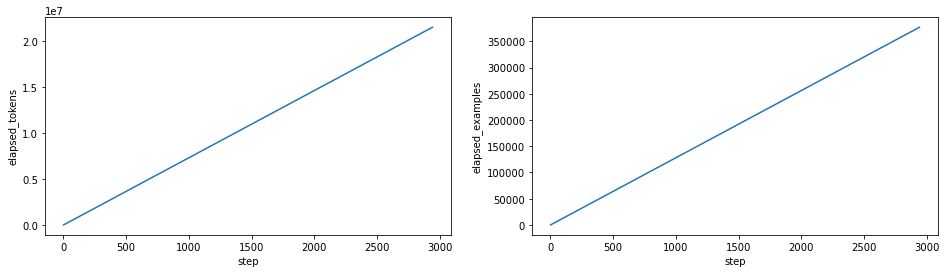

In [14]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

sns.lineplot(x = C["step"], y = df_result_1["elapsed_tokens"], ax = axes[0])
sns.lineplot(x = df_result_1["step"], y = df_result_1["elapsed_examples"], ax = axes[1])

Both elapsed_tokens and elapsed_examples grow linearly as the steps.

<AxesSubplot:>

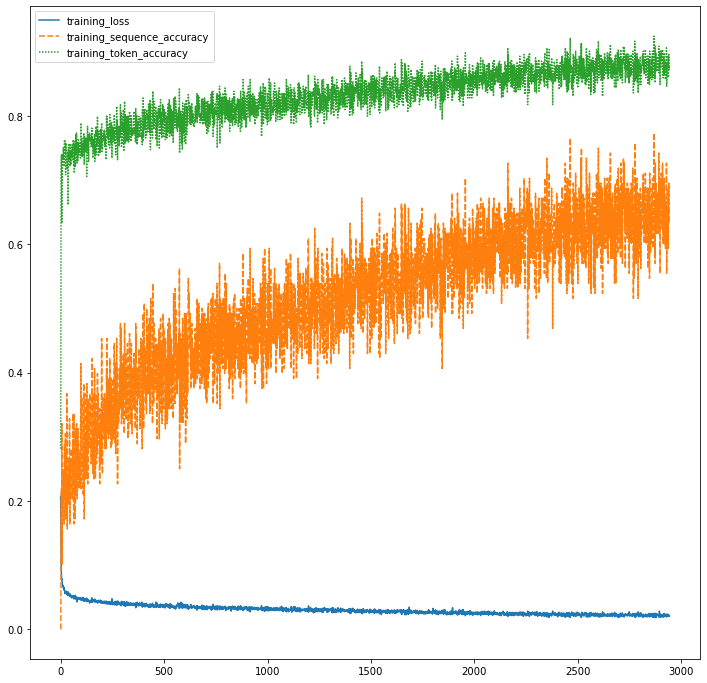

In [20]:
_, ax = plt.subplots(figsize=(12, 12))

sns.lineplot(data=df_result_1[["training_loss", "training_sequence_accuracy", "training_token_accuracy"]], ax = ax)

Note: "training_token_accuracy" is more or less useless, since our prompt by tokenizer for NLP tasks, whose token has little contribution for our prediction. Also, the model is still improving steadily, so maybe more steps would be beneficial.

Now, we examine the model's performance on the test set.

In [27]:
test_path = './data/d1/gpt_samples_prepared_valid.jsonl'
df_test_1 = pd.read_json(test_path, lines = True)
df_test_1

,prompt,completion
0,rn3rk1 pbpp1pp1 1p2pq1p 8 3p4 2pb1p2 pp1nn1pp ...,0.9
1,rnbqkbnr pp1ppp1p 6p1 2p5 4p3 2p5 pp1pnppp rnb...,0.5
2,kr5b p6p 2pq2p1 3p4 4p3 p2bq3 1pp2ppp 2krr3 w ->,1.0
3,7k 3qr2p p5p1 1pp1bp2 3n1p2 3pb2p p2q2p1 1r1b2...,0.9
4,2r3k1 pp3ppp 2p5 2qp4 8 1p2rp1p p1pq2p1 r4r1k ...,0.3
...,...,...
495,2r5 1pp2p2 k4pp1 2b3p1 8 1pp5 k2r4 8 w ->,1.0
496,4k2r p1p5 1p1pp1p1 7r 2pp1pr1 p1p1b3 6k1 8 w ->,0.0
497,5bnr rpq2kpp p3bp2 3p4 qp1n1b2 2p2p2 p5pp rn3r...,1.0
498,r4rk1 p1ppn1pp 1p2p3 7q 2ppqp2 p1p1r3 6pp r1b3...,0.4


In [29]:
ft_model_id = "ada:ft-personal-2023-03-01-23-19-00"

# requesting model prediction through openai API
@retry(wait=wait_random_exponential(min=5, max=120), stop=stop_after_attempt(10))
def predict(fen, model_id, **kwargs):
    result = openai.Completion.create(
        model = model_id,
        prompt = fen,
        **kwargs)
    return result["choices"][0]["text"]

# convert the return result from stirng to float
def to_float(str):
    if isinstance(str, type(0.1)):
        # data from csv is already in float
        return str
    str = str.strip()
    try:
        f = float(str)
    except:
        # in case the return value is not a float
        print(str)
        f = -1.0
    return f

In [30]:
# commented out to prevent accidently running it
# df_test_1["predicted"] = df_test_1["prompt"].apply(lambda x : predict(x, max_tokens = 3, temperature = 0.5, presence_penalty = -2))
# df_test_1["predicted"] = df_test_1["predicted"].apply(to_float, ft_model_id)
# df_test_1.to_csv("./test_result/test_1.csv")

In [28]:
df_test_result_1 = pd.read_csv("./test_result/test_1.csv")
df_test_result_1

,Unnamed: 0,prompt,completion,predicted
0,0,rn3rk1 pbpp1pp1 1p2pq1p 8 3p4 2pb1p2 pp1nn1pp ...,0.9,0.9
1,1,rnbqkbnr pp1ppp1p 6p1 2p5 4p3 2p5 pp1pnppp rnb...,0.5,0.4
2,2,kr5b p6p 2pq2p1 3p4 4p3 p2bq3 1pp2ppp 2krr3 w ->,1.0,1.0
3,3,7k 3qr2p p5p1 1pp1bp2 3n1p2 3pb2p p2q2p1 1r1b2...,0.9,0.9
4,4,2r3k1 pp3ppp 2p5 2qp4 8 1p2rp1p p1pq2p1 r4r1k ...,0.3,0.3
...,...,...,...,...
495,495,2r5 1pp2p2 k4pp1 2b3p1 8 1pp5 k2r4 8 w ->,1.0,1.0
496,496,4k2r p1p5 1p1pp1p1 7r 2pp1pr1 p1p1b3 6k1 8 w ->,0.0,0.0
497,497,5bnr rpq2kpp p3bp2 3p4 qp1n1b2 2p2p2 p5pp rn3r...,1.0,0.8
498,498,r4rk1 p1ppn1pp 1p2p3 7q 2ppqp2 p1p1r3 6pp r1b3...,0.4,0.4


Below is a scatter plot for true and predicted variable. Ideadly, points should be on the blue line (true = predicted variable). The less transparent a dot is, the more data point on that location.

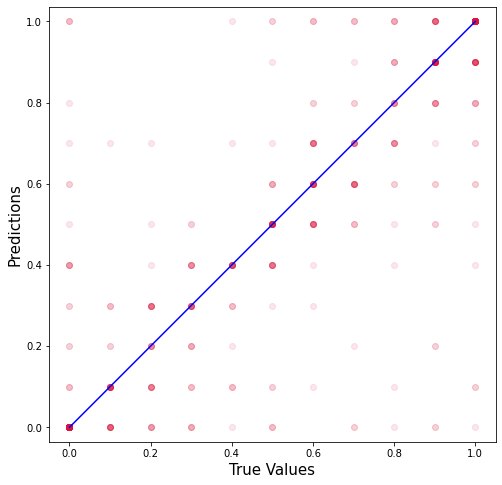

In [33]:
pred_test = df_test_result_1["predicted"]
y_test = df_test_result_1["completion"]

# visualize the predicted and true value
plt.figure(figsize=(8,8))
plt.scatter(y_test, pred_test, c='crimson', alpha = 0.1)

p1 = max(max(pred_test), max(y_test))
p2 = min(min(pred_test), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()


As you can see, the model predicted most data points rights. The one model predicted wrong are often close to the the correct class (dot near the blue line is more dense).

Print r2 and mean absolute value. The result suggests the model already perform better than the linear and polynomial model.

In [66]:
r2_score(df_test["completion"], df_test["predicted"])

0.6828283313869271

In [67]:
mean_absolute_error(df_test["completion"], df_test["predicted"])

0.10720000000000002

In [35]:
df_test_result_1[df_test_result_1["completion"] - df_test_result_1["predicted"]  != 0]

,Unnamed: 0,prompt,completion,predicted
1,1,rnbqkbnr pp1ppp1p 6p1 2p5 4p3 2p5 pp1pnppp rnb...,0.5,0.4
5,5,7k 7p p2q2p1 1pp2p2 3brp2 3p1b1p p2q2p1 1r5k w ->,1.0,0.4
6,6,4rb1r q1pk2pn 2ppq3 4p2p 4p1bb 2pp1n2 pp1n1ppp...,0.9,0.8
8,8,r3qrk1 p1ppn1pp 1p2p3 4q3 2pp1p2 p1p2r2 3b2pp ...,0.5,1.0
9,9,r3r1k1 ppp2pbp 2nq1np1 3p2n1 3p2b1 2nbb1qp ppp...,0.5,0.3
...,...,...,...,...
490,490,rnbqk1nr p1pppp2 6pp 8 4p3 2qpb3 p1p2ppp 1r2kb...,1.0,0.9
491,491,rn3rk1 pq5p 4p1p1 5p2 5n2 6p1 ppp1pp1p 1rq2rk1...,0.6,0.8
492,492,r1bqkbnr pp1ppppp 2n5 2p5 2p4p 2n5 pp1pppp1 r1...,0.4,0.3
494,494,r4rk1 p4ppp 2pbqn2 1p2p3 2pp4 1p3npb pb3p1p rn...,0.8,1.0


With only 900k samples, the fine-tuned GPT model already performs decently. Now, I add more data point to the model.

## Fine Tune the model, second round

Here, I further fine tune the GPT model from my fine tuned version abvove.

This time I use the unprocessed raw FEN string as the training sample.

In [122]:
df_2 = pd.read_csv(file_address)

In [123]:
# select last 200k samples
df_2 = df_2[-200000:]
df_2

,FEN,Evaluation
12758035,7r/8/8/2p2pk1/5p2/2Pr1B2/4NK1p/7R b - - 13 78,-564
12758036,8/8/7r/2p2pk1/5p2/2Pr1B2/4NK1p/7R w - - 14 79,-407
12758037,8/8/7r/2p2pk1/5p2/2Pr1B2/4N1Kp/7R b - - 15 79,-366
12758038,8/8/8/2p2pk1/5p2/2Prr3/4NKBp/7R w - - 20 82,-632
12758039,8/8/8/2p2pk1/5p2/2Prr3/4NKBR/8 b - - 0 82,-670
...,...,...
12958030,r1bqkb1r/pp3ppp/1nn1p3/3pP3/3P1P2/1B3N2/PP2Q1P...,+6
12958031,r2qkb1r/pp1b1ppp/1nn1p3/3pP3/3P1P2/1B3N2/PP2Q1...,+84
12958032,r2qkb1r/pp1b1ppp/1nn1p3/3pP3/3P1P2/1BN2N2/PP2Q...,0
12958033,r2qkb1r/pp1b1ppp/1n2p3/n2pP3/3P1P2/1BN2N2/PP2Q...,+115


In [124]:
df_2 = process_df(df_2)
df_2["Evaluation_norm"] = 1 / (1 + 10 ** (-df_2["Evaluation"] / 400))
df_2.drop(columns = ["Evaluation", "checkmate"], inplace = True)
df_2["Evaluation_norm"] = df_2["Evaluation_norm"].apply(lambda x : round(x, 1))

In [126]:
# # additional 120k data
save_dataset_for_GPT(df[:120000], "./data/d2/gpt_samples.csv")

In [127]:
# !openai tools fine_tunes.prepare_data -f ./data/d2/gpt_samples.csv
# !openai api fine_tunes.create -t data/d2/gpt_samples_prepared_train.jsonl -m ada:ft-personal-2023-03-01-23-19-00

Here, I made a couple mistakes:

1. I forgot to replace '/' with ' ' in the training. However, I think the impact will be limited, as the model should be able to learn the meaning of '/'.
2. I should at least remove the full turn clock from the FEN, so there would be less noise.

### Results

First, let's examine the result during the model's training.

In [132]:
result2_path = './training_result/result_2.csv'
df_result_2 = pd.read_csv(result2_path)
df_result_2

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy
0,1,8320,128,0.095375,0.117188,0.666667
1,2,16640,256,0.069304,0.210938,0.734375
2,3,24960,384,0.056383,0.312500,0.770833
3,4,33280,512,0.056308,0.171875,0.723958
4,5,41600,640,0.055088,0.265625,0.755208
...,...,...,...,...,...,...
3715,3716,31126016,475648,0.022360,0.648438,0.882812
3716,3717,31134336,475776,0.021549,0.671875,0.890625
3717,3718,31142656,475904,0.022770,0.625000,0.875000
3718,3719,31150976,476032,0.022029,0.625000,0.875000


<AxesSubplot:>

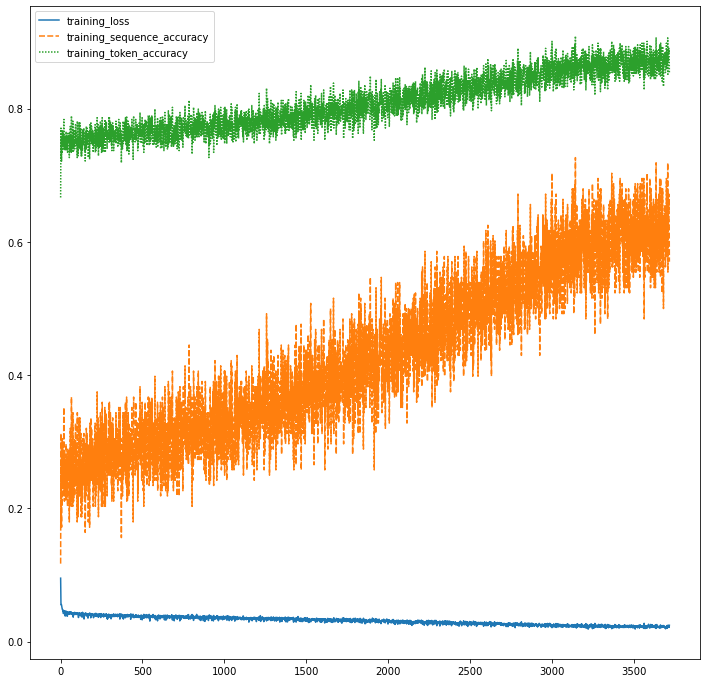

In [133]:
_, ax = plt.subplots(figsize=(12, 12))

sns.lineplot(data=df_result_2[["training_loss", "training_sequence_accuracy", "training_token_accuracy"]], ax = ax)

Note: "training_token_accuracy" is more or less useless, since our prompt by tokenizer for NLP tasks, whose token has little contribution for our prediction. Also, same as above, the model is still improving steadily, so maybe more steps would be beneficial.

### Test

Now, let's test its performance on the test set.

In [136]:
test_path2 = './data/d2/gpt_samples_prepared_valid.jsonl'
df_test_2 = pd.read_json(test_path2, lines = True)
df_test_2

,prompt,completion
0,4r1k1/pn3qB1/1p2pP2/2r3p1/6Qp/7R/P4PPP/5RK1 w ...,0.9
1,5r1k/1pr4p/p1bnpp2/8/3R1P2/2PBN1R1/P2K2PP/8 b ...,0.5
2,r2r2k1/2Q1npq1/2p1p1pR/8/3PB3/P7/5PPP/3R2K1 w ...,0.5
3,8/3R2kp/p1p3p1/4p3/1PP2r1P/P7/6K1/8 b - - 1 58 ->,0.4
4,8/6pk/p1b3qp/8/3Q4/1PP1NrB1/P6P/R5K1 b - - 9 4...,0.9
...,...,...
995,r4rk1/p1q1ppbp/6p1/2Q2b2/3B4/5P2/PPP3PP/2KR1B1...,0.2
996,5rk1/ppR2ppp/2b5/2r1P3/8/1B6/PP3PPP/4R1K1 b - ...,0.8
997,r4r1k/1p1q1ppp/pn2p3/2NnP1B1/8/8/PP2QPPP/R4RK1...,0.5
998,5bk1/5ppp/p7/1r6/4q3/1QP3BP/P4PP1/5RK1 w - - 3...,0.7


In [34]:
df_test_2["predicted"] = df_test_2["prompt"].apply(lambda x : x)
df_test_2

,prompt,completion,predicted
0,4r1k1/pn3qB1/1p2pP2/2r3p1/6Qp/7R/P4PPP/5RK1 w ...,0.9,4r1k1/pn3qB1/1p2pP2/2r3p1/6Qp/7R/P4PPP/5RK1 w ...
1,5r1k/1pr4p/p1bnpp2/8/3R1P2/2PBN1R1/P2K2PP/8 b ...,0.5,5r1k/1pr4p/p1bnpp2/8/3R1P2/2PBN1R1/P2K2PP/8 b ...
2,r2r2k1/2Q1npq1/2p1p1pR/8/3PB3/P7/5PPP/3R2K1 w ...,0.5,r2r2k1/2Q1npq1/2p1p1pR/8/3PB3/P7/5PPP/3R2K1 w ...
3,8/3R2kp/p1p3p1/4p3/1PP2r1P/P7/6K1/8 b - - 1 58 ->,0.4,8/3R2kp/p1p3p1/4p3/1PP2r1P/P7/6K1/8 b - - 1 58 ->
4,8/6pk/p1b3qp/8/3Q4/1PP1NrB1/P6P/R5K1 b - - 9 4...,0.9,8/6pk/p1b3qp/8/3Q4/1PP1NrB1/P6P/R5K1 b - - 9 4...
...,...,...,...
995,r4rk1/p1q1ppbp/6p1/2Q2b2/3B4/5P2/PPP3PP/2KR1B1...,0.2,r4rk1/p1q1ppbp/6p1/2Q2b2/3B4/5P2/PPP3PP/2KR1B1...
996,5rk1/ppR2ppp/2b5/2r1P3/8/1B6/PP3PPP/4R1K1 b - ...,0.8,5rk1/ppR2ppp/2b5/2r1P3/8/1B6/PP3PPP/4R1K1 b - ...
997,r4r1k/1p1q1ppp/pn2p3/2NnP1B1/8/8/PP2QPPP/R4RK1...,0.5,r4r1k/1p1q1ppp/pn2p3/2NnP1B1/8/8/PP2QPPP/R4RK1...
998,5bk1/5ppp/p7/1r6/4q3/1QP3BP/P4PP1/5RK1 w - - 3...,0.7,5bk1/5ppp/p7/1r6/4q3/1QP3BP/P4PP1/5RK1 w - - 3...


In [38]:
ft_model_id_2 = "ada:ft-personal-2023-03-02-06-45-01"

# df_test_2["predicted"] = df_test_2["prompt"].apply(lambda x : predict(x, ft_model_id_2, max_tokens = 3, temperature = 0.5, presence_penalty = -2))
# df_test_2.to_csv("./test_result/test_2.csv")

In [137]:
df_test_2 = pd.read_csv("./test_result/test_2.csv")
df_test_2

,Unnamed: 0,prompt,completion,predicted
0,0,4r1k1/pn3qB1/1p2pP2/2r3p1/6Qp/7R/P4PPP/5RK1 w ...,0.9,0.9
1,1,5r1k/1pr4p/p1bnpp2/8/3R1P2/2PBN1R1/P2K2PP/8 b ...,0.5,0.5
2,2,r2r2k1/2Q1npq1/2p1p1pR/8/3PB3/P7/5PPP/3R2K1 w ...,0.5,0.5
3,3,8/3R2kp/p1p3p1/4p3/1PP2r1P/P7/6K1/8 b - - 1 58 ->,0.4,0.5
4,4,8/6pk/p1b3qp/8/3Q4/1PP1NrB1/P6P/R5K1 b - - 9 4...,0.9,0.7
...,...,...,...,...
995,995,r4rk1/p1q1ppbp/6p1/2Q2b2/3B4/5P2/PPP3PP/2KR1B1...,0.2,0.5
996,996,5rk1/ppR2ppp/2b5/2r1P3/8/1B6/PP3PPP/4R1K1 b - ...,0.8,0.7
997,997,r4r1k/1p1q1ppp/pn2p3/2NnP1B1/8/8/PP2QPPP/R4RK1...,0.5,0.5
998,998,5bk1/5ppp/p7/1r6/4q3/1QP3BP/P4PP1/5RK1 w - - 3...,0.7,0.8


In [59]:
df_test_2["predicted"] = df_test_2["predicted"].apply(to_float, ft_model_id)

In [61]:
r2_score(df_test_2["completion"], df_test_2["predicted"])

0.6352978805685373

In [60]:
mean_absolute_error(df_test_2["completion"], df_test_2["predicted"])

0.09359999999999999

Here, note that the r2 score is slightly lower. However, the mean absolute error is also lower, which suggests that the model performs slightly better, but the variation within the data decreased significantly. 
The reason for decreased variation is because there are more samples in my test set this times: last time, I only used 500 samples to increase speed and save quota.

One reason why the model performance only improved limitedly could potentially because of the different training data format: idealy, I should use the same format of data for both rounds; otherwise, the model may not have enough data for either format. Also, the mistake I made above may negativly impacted the model performance.

### Future Steps

To improve the model further, the following steps can be done:
    <ol>
      <li>more training samples and smaller bin size</li>
      <li>a more efficient representation of the board. Currently, each FEN string consumes about 40 tokens, which is expensive for training. However, if we transform the FEN string to another shorter representation (potentially using more possible characters), we can include more samples with the same cost</li>
      <li>ask the model to return the best 2 or 3 prediction (rather than only one). We could average them to get a better prediction</li>
    </ol>

### Error Analysis

In [140]:
df_test_2["error"] = df_test_2["completion"] - df_test_2["predicted"]
df_test_2["error"] = abs(df_test_2["error"])
df_test_2

,Unnamed: 0,prompt,completion,predicted,error
0,0,4r1k1/pn3qB1/1p2pP2/2r3p1/6Qp/7R/P4PPP/5RK1 w ...,0.9,0.9,0.0
1,1,5r1k/1pr4p/p1bnpp2/8/3R1P2/2PBN1R1/P2K2PP/8 b ...,0.5,0.5,0.0
2,2,r2r2k1/2Q1npq1/2p1p1pR/8/3PB3/P7/5PPP/3R2K1 w ...,0.5,0.5,0.0
3,3,8/3R2kp/p1p3p1/4p3/1PP2r1P/P7/6K1/8 b - - 1 58 ->,0.4,0.5,0.1
4,4,8/6pk/p1b3qp/8/3Q4/1PP1NrB1/P6P/R5K1 b - - 9 4...,0.9,0.7,0.2
...,...,...,...,...,...
995,995,r4rk1/p1q1ppbp/6p1/2Q2b2/3B4/5P2/PPP3PP/2KR1B1...,0.2,0.5,0.3
996,996,5rk1/ppR2ppp/2b5/2r1P3/8/1B6/PP3PPP/4R1K1 b - ...,0.8,0.7,0.1
997,997,r4r1k/1p1q1ppp/pn2p3/2NnP1B1/8/8/PP2QPPP/R4RK1...,0.5,0.5,0.0
998,998,5bk1/5ppp/p7/1r6/4q3/1QP3BP/P4PP1/5RK1 w - - 3...,0.7,0.8,0.1


In [141]:
df_test_2.sort_values(by = ["error"], ascending = False).head()

,Unnamed: 0,prompt,completion,predicted,error
203,203,8/8/5KP1/1k3P2/5r2/p7/7R/8 b - - 1 57 ->,1.0,0.0,1.0
327,327,3r1rk1/pp3ppp/8/1N2n3/3p1b2/6B1/PP3P1P/R4RK1 w...,0.8,0.1,0.7
90,90,4k2r/1R3p1p/p2qp1p1/2bp4/4nBQ1/3N2PP/5P1K/8 b ...,1.0,0.3,0.7
578,578,r5k1/3br3/p1p3pp/3pPp2/1P1P1P2/P2N4/6PP/R4RK1 ...,0.9,0.3,0.6
977,977,rn1q1rk1/p4ppp/1p1bp3/8/2P5/2P1BB2/PP4PP/RN1QR...,1.0,0.4,0.6


This time, the GPT model learnt to only make prediction between 0 and 1.

Unnamed: 0                                         203
prompt        8/8/5KP1/1k3P2/5r2/p7/7R/8 b - - 1 57 ->
completion                                         1.0
predicted                                          0.0
error                                              1.0
Name: 203, dtype: object


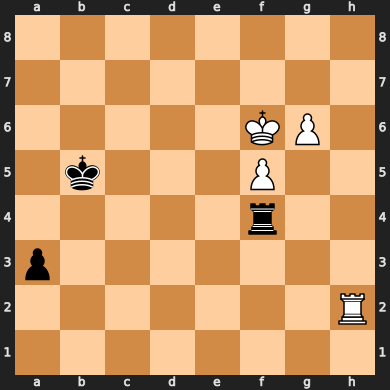

In [151]:
print(df_test_2.iloc[203])
chess.Board("8/8/5KP1/1k3P2/5r2/p7/7R/8 b - - 1 57")

It is difficult to understand why GPT predict this game as 0.0.  White has a clear advantage in this board, because of one extra pawn. In this end game, it is difficult for black to defend pawn from promotion. However, this type of game probably is not common in the dataset, so it could be hard for GPT to predict it.

Unnamed: 0                                                  327
prompt        3r1rk1/pp3ppp/8/1N2n3/3p1b2/6B1/PP3P1P/R4RK1 w...
completion                                                  0.8
predicted                                                   0.1
error                                                       0.7
Name: 327, dtype: object


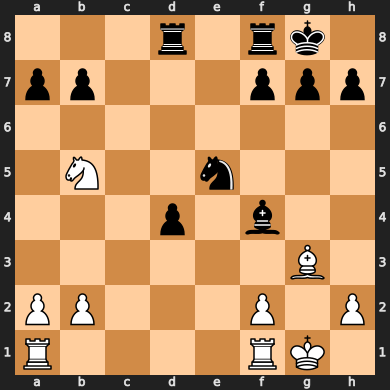

In [154]:
print(df_test_2.iloc[327])
chess.Board("3r1rk1/pp3ppp/8/1N2n3/3p1b2/6B1/PP3P1P/R4RK1 w - - 0 23")

Here, the black bishop is about to be captured. After that, the white has one extra bishop vs two extra pawn from black, which is an advantage. It is difficult to analyze the board otherwise, since it is still a early game.

## Conclusion

1. From pieces information (what is on the board) alone, board strength can be predicted fairly well
2. GPT3, or similar NLP models, are promising in this type of tasks
3. One strategy to predict outcome of board game could be represeenting it as a string, and apply transfer learning techniques to it.
